In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split


seed = np.random.seed(42)

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 15) 
pd.set_option('display.max_rows', 50)

# 1. Data Acquisition

We read each patient in the train and test folder given the path.   
For the rest of this section, all visualizations will be done on the first patient in the training dictionary.

In [3]:
def read_train_test_folder(path='resources'):
    patient_files = [patient for patient in os.listdir(path) if patient.endswith('.csv')]
    patient_dict = {}

    for index,patient in enumerate(patient_files):
        patient_dict[index] = pd.read_csv(os.path.join(path,patient))
    
    return patient_dict

In [4]:
TRAIN_PATH = 'resources/Ohio2020_processed/train'
TEST_PATH = 'resources/Ohio2020_processed/test'

In [5]:
train_dict = read_train_test_folder(TRAIN_PATH)
test_dict = read_train_test_folder(TEST_PATH)

In [6]:
train_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13109 entries, 0 to 13108
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   5minute_intervals_timestamp  13109 non-null  float64
 1   missing_cbg                  13109 non-null  float64
 2   cbg                          11946 non-null  float64
 3   finger                       553 non-null    float64
 4   basal                        13089 non-null  float64
 5   hr                           0 non-null      float64
 6   gsr                          5981 non-null   float64
 7   carbInput                    73 non-null     float64
 8   bolus                        304 non-null    float64
dtypes: float64(9)
memory usage: 921.9 KB


In [7]:
train_dict[0].describe()

,5minute_intervals_timestamp,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus
count,"13,109.000","13,109.000","11,946.000",553.000,"13,089.000",0.000,"5,981.000",73.000,304.000
mean,"6,042,309.822",0.089,137.102,107.788,0.463,NaN,0.850,59.178,4.016
std,"3,784.690",0.284,55.027,84.550,0.310,NaN,4.678,29.756,2.861
min,"6,035,755.297",0.000,40.000,0.000,0.000,NaN,0.000,1.000,0.100
25%,"6,039,032.559",0.000,94.000,0.000,0.400,NaN,0.024,30.000,2.000
50%,"6,042,309.822",0.000,127.000,102.000,0.400,NaN,0.073,57.000,3.200
75%,"6,045,587.084",0.000,171.000,164.000,0.400,NaN,0.252,85.000,5.425
max,"6,048,864.347",1.000,369.000,315.000,2.100,NaN,71.036,100.000,11.400


<h2> 1.2 Continuous Blood Glucose Visualization

Plot of the $\textbf{Continuous Blood Glucose}$ parameter of patient 0 for 1000 time instances.   
When the whole CBG is plotted, it is not clearly visible the peaks that are cut due to the $[40,400]$ limits.

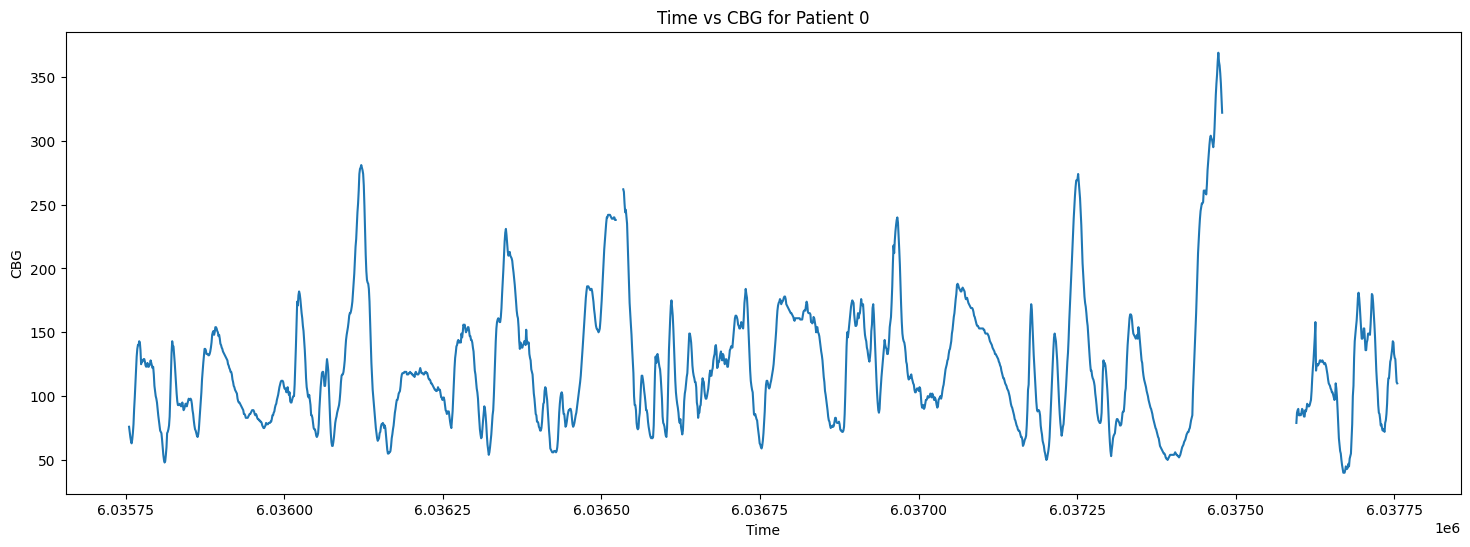

In [8]:
plt.figure(figsize=(18,6))
plt.plot(train_dict[0]["5minute_intervals_timestamp"][:2000],train_dict[0]["cbg"][:2000],label="Patient 0")
plt.title(f'Time vs CBG for Patient 0')
plt.xlabel("Time")
plt.ylabel("CBG")
plt.show()

<h2> 1.3 Correlation Matrix between Continuous Blood Glucose and other features

In [9]:
# using iloc to exclude the first column(time stamp) from correlation matrix 
corr_matrix = train_dict[0].iloc[:,1:].corr()

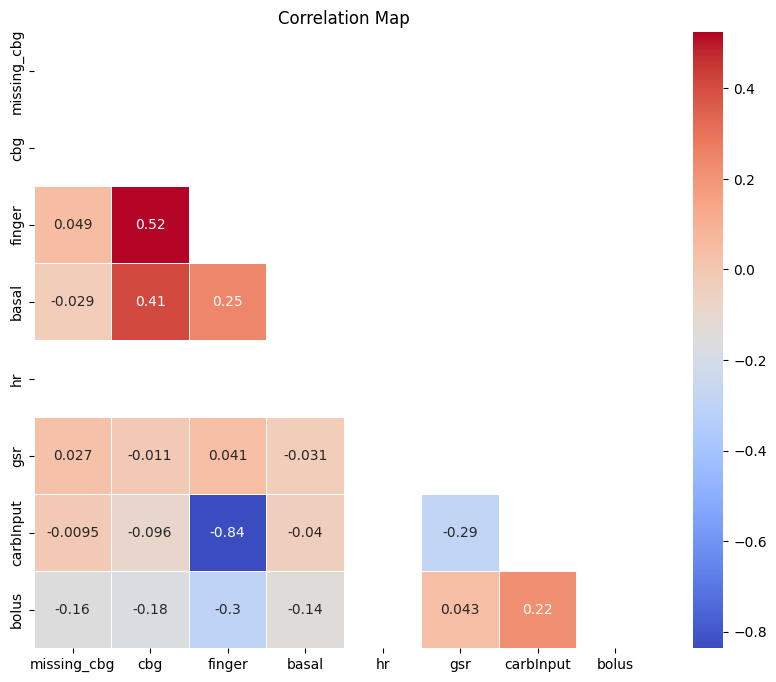

In [10]:
plt.figure(figsize=(10,8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,mask=mask,annot=True,cmap='coolwarm',linewidths=0.5)
plt.title("Correlation Map")
plt.show()

# 2. Data Pre-Processing

In [11]:
train_patient0 = train_dict[0]

In [12]:
percentile_80 = train_patient0["cbg"].quantile(0.8)
print("Percentile 80: ", percentile_80)

Percentile 80:  182.0


In [13]:
percentile_80_patient0 = train_dict[0][train_dict[0]["cbg"] < percentile_80]

percentile_80_patient0

,5minute_intervals_timestamp,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus
0,"6,035,755.297",0.000,76.000,80.000,NaN,NaN,0.337,NaN,NaN
1,"6,035,756.297",0.000,72.000,NaN,NaN,NaN,0.318,NaN,NaN
2,"6,035,757.297",0.000,68.000,NaN,NaN,NaN,0.343,NaN,NaN
3,"6,035,758.297",0.000,65.000,NaN,NaN,NaN,0.360,NaN,NaN
4,"6,035,759.297",0.000,63.000,NaN,NaN,NaN,0.366,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13013,"6,048,769.339",0.000,170.000,NaN,0.400,NaN,12.068,NaN,NaN
13014,"6,048,770.339",0.000,174.000,NaN,0.400,NaN,10.459,NaN,NaN
13015,"6,048,771.339",0.000,178.000,NaN,0.400,NaN,11.378,NaN,NaN
13016,"6,048,772.339",0.000,179.000,NaN,0.400,NaN,13.001,NaN,NaN


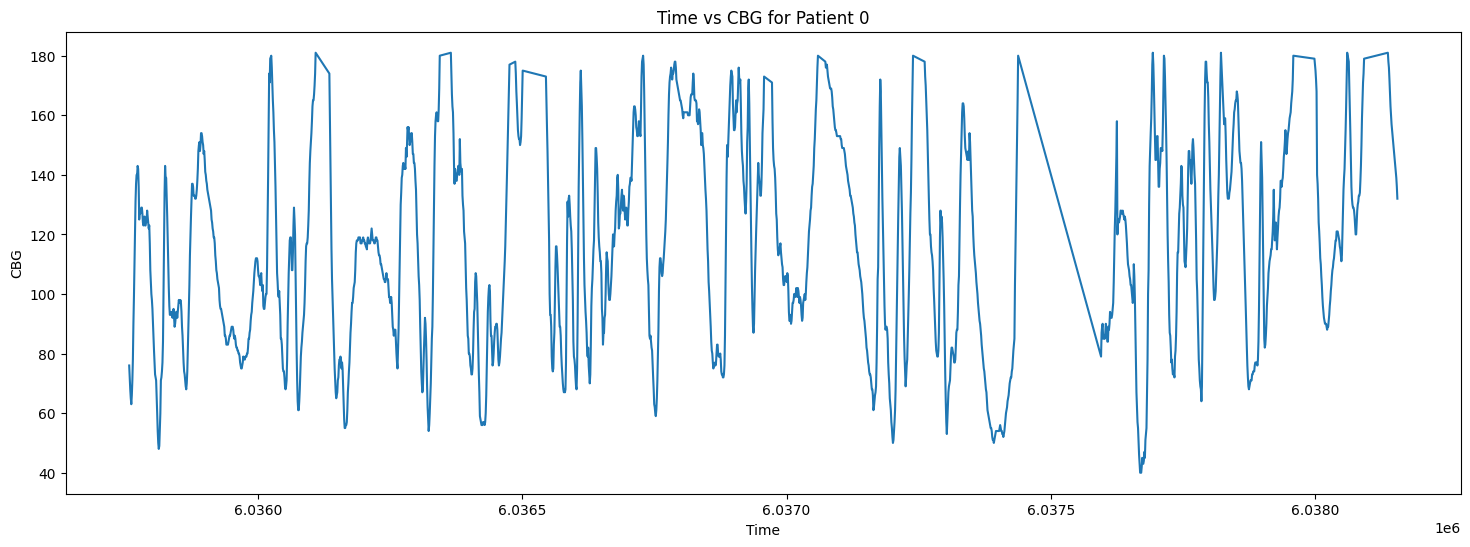

In [14]:
plt.figure(figsize=(18,6))
plt.plot(percentile_80_patient0["5minute_intervals_timestamp"][:2000],percentile_80_patient0["cbg"][:2000],label="Patient 0")
plt.title(f'Time vs CBG for Patient 0')
plt.xlabel("Time")
plt.ylabel("CBG")
plt.show()

<h2> Percentile 80th splitting 

The 80th percentile values that were excluded will be masked into windows of 100 values. Furthermore, we ensure that those 80th percentile have no missing cbg value around.

In [15]:
masked_points = np.argwhere((train_patient0["cbg"]  >= percentile_80) & (train_patient0["missing_cbg"] == 0))

random_point = masked_points.flatten()[0]

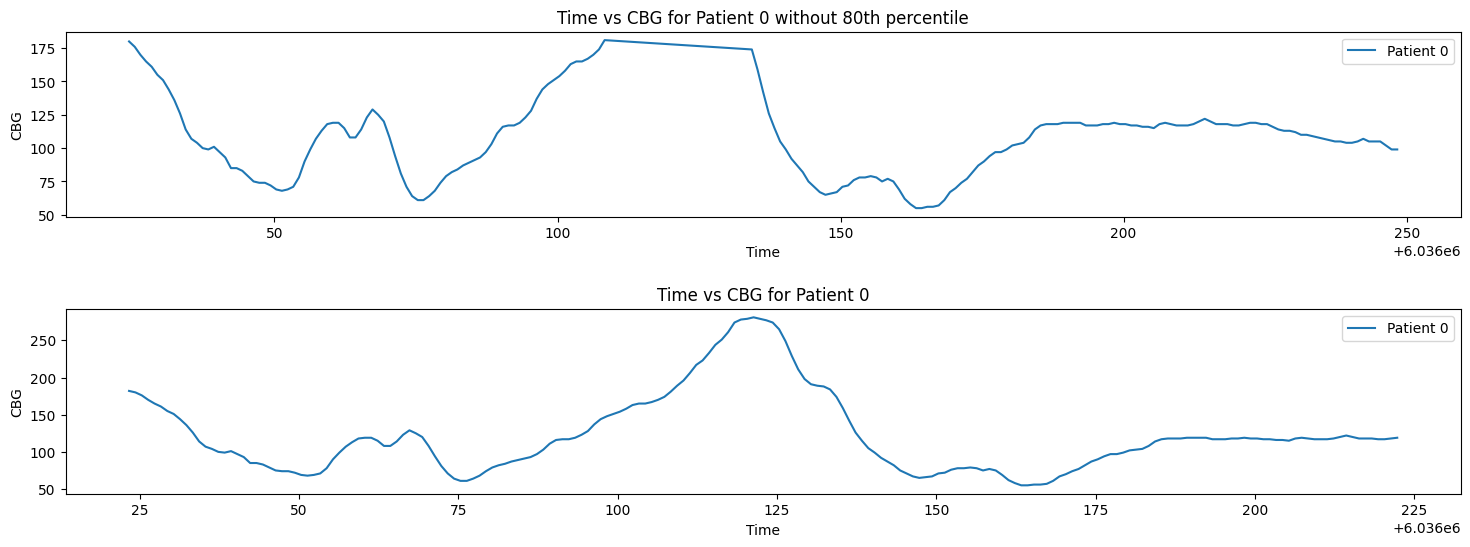

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 6))
plt.subplots_adjust(hspace=0.5)

ax1.plot(percentile_80_patient0["5minute_intervals_timestamp"][random_point:random_point+200],percentile_80_patient0["cbg"][random_point:random_point+200],label="Patient 0")
ax1.set_title(f'Time vs CBG for Patient 0 without 80th percentile')
ax1.set_xlabel("Time")
ax1.set_ylabel("CBG")
ax1.legend()

ax2.plot(train_patient0["5minute_intervals_timestamp"][random_point:random_point+200],train_patient0["cbg"][random_point:random_point+200],label="Patient 0")
ax2.set_title(f'Time vs CBG for Patient 0')
ax2.set_xlabel("Time")
ax2.set_ylabel("CBG")
ax2.legend()

plt.show()

<h2> Window Size </h2>

Hint 2: The masked patches should be of a similar length to the missing patches in the missing
data.  
Hint 3: Choose input sequence lengths that matches or exceed the longest missing patches in the
censored data.

In [17]:
def longest_consecutive_sequence(nums: list[int]) -> int:
    numset = set(nums)
    maxLen = 0
    lenStart = 0
    maxStart = 0 
    
    for x in nums:
        if x-1 not in numset:
            curLen = 1
            lenStart = x
        else:
            curLen+=1
            x +=1
        if maxLen < curLen:
            maxLen = curLen
            maxStart = lenStart

    return maxLen, maxStart

In [18]:
# LONGEST SEQUENCE OF CONSECUTIVE NUMBERS IN AN ARRAY OR LIST 
missing_cbg = np.argwhere(train_patient0["missing_cbg"] > 0).flatten()

maxSequence, beginMaxSequence = longest_consecutive_sequence(missing_cbg)

print("LONGEST MISSING PATCH LENGTH:", maxSequence)

LONGEST MISSING PATCH LENGTH: 235


In [19]:
# SANITY CHECK 
miss_data = train_patient0["missing_cbg"][beginMaxSequence:beginMaxSequence+maxSequence]

if np.all(miss_data > 0):
    print("LONGEST SEQUENCE")
else:
    print("Sanity check failed")

LONGEST SEQUENCE


Given the following observation, we know that the longest missing patch has length 235.  
$\textbf{Window Size}$ must be either $235$ or wider.  

A sensible decision is to take $\textbf{Window} = 300$

In [20]:
y_data = train_patient0["5minute_intervals_timestamp"][beginMaxSequence-125:beginMaxSequence+maxSequence+125]
x_data = train_patient0["cbg"][beginMaxSequence-125:beginMaxSequence+maxSequence+125]

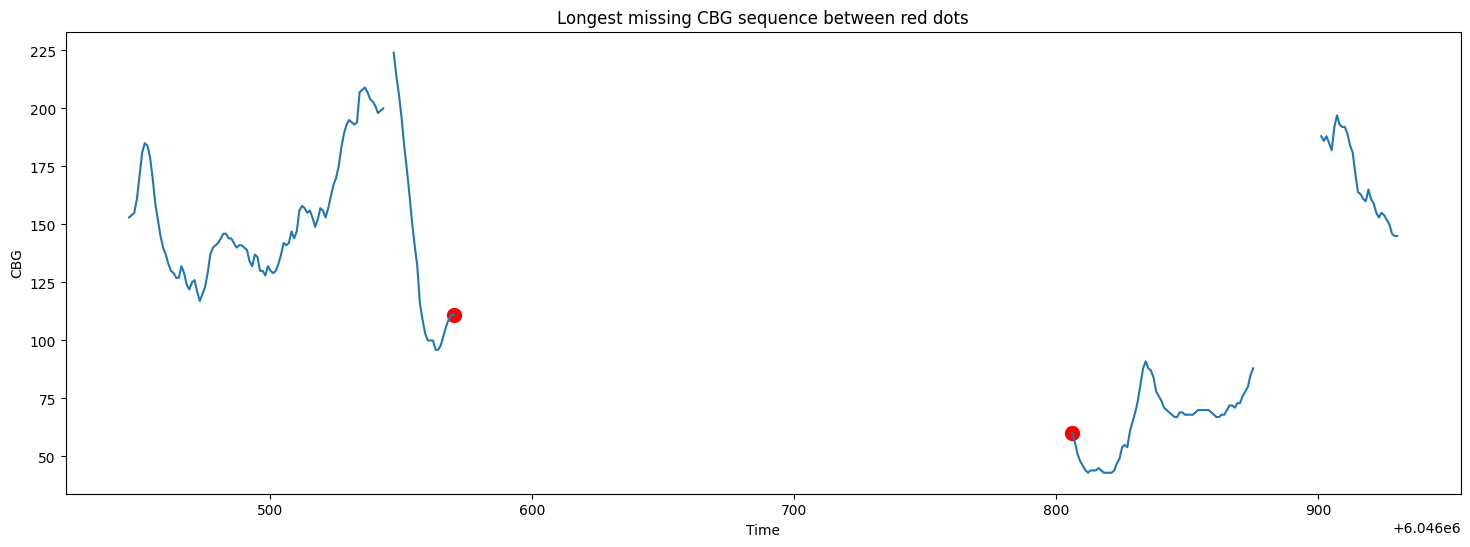

In [21]:
plt.figure(figsize=(18,6))
plt.plot(y_data,x_data,label="Patient 0")
plt.scatter(train_patient0["5minute_intervals_timestamp"][beginMaxSequence-1],train_patient0["cbg"][beginMaxSequence-1],color='red', s=100, label='Red Dot')
plt.scatter(train_patient0["5minute_intervals_timestamp"][beginMaxSequence+maxSequence],train_patient0["cbg"][beginMaxSequence+maxSequence],color='red', s=100, label='Red Dot')

plt.title(f'Longest missing CBG sequence between red dots')
plt.xlabel("Time")
plt.ylabel("CBG")
plt.show()

<h2> 2.2 Window splitting </h2>

$\textbf{TEST SET}$ Every time we find a point which was cut due to 80th percentile, we mask it in a 300 size window (100 value before, and 200 values after).

In [22]:
MASK_WINDOWS = np.empty((0,300))
TRUE_WINDOWS  = np.empty((0,300))

In [23]:
def window_splitting(patient, masked_points):
    windows = []

    for point in masked_points:
        if point-99 >= 0 and point + 201 < len(patient["cbg"]):
            windows.append(patient["cbg"][point-99:point+201])
    
    return windows

In [24]:
import traceback

try:
    for index in train_dict:

        # CUT values that are above percentile, put NAN values if > 80th
        masked_dict = train_dict[index].where(train_dict[index]['cbg'] < percentile_80, np.nan)

        # TAKE ALL POINTS THAT WERE CUT DUE TO 80TH PERCENTILE BUT without missing value 
        masked_points = np.argwhere((train_dict[index]["cbg"]  >= percentile_80) & (train_dict[index]["missing_cbg"] == 0)).flatten()

        # ground truth windows
        TRUE_WINDOWS = window_splitting(train_dict[index],masked_points)

        # masked windows 
        MASK_WINDOWS = window_splitting(masked_dict,masked_points)

        MASK_WINDOWS = np.vstack([MASK_WINDOWS,MASK_WINDOWS])
        TRUE_WINDOWS = np.vstack([TRUE_WINDOWS,TRUE_WINDOWS])

except Exception as e:
    print("EXCEPTION: ",e)
    traceback.print_exc()

In [25]:
print("TRAIN SET:", np.shape(MASK_WINDOWS))
print("TEST SET:", np.shape(TRUE_WINDOWS))


TRAIN SET: (5016, 300)
TEST SET: (5016, 300)


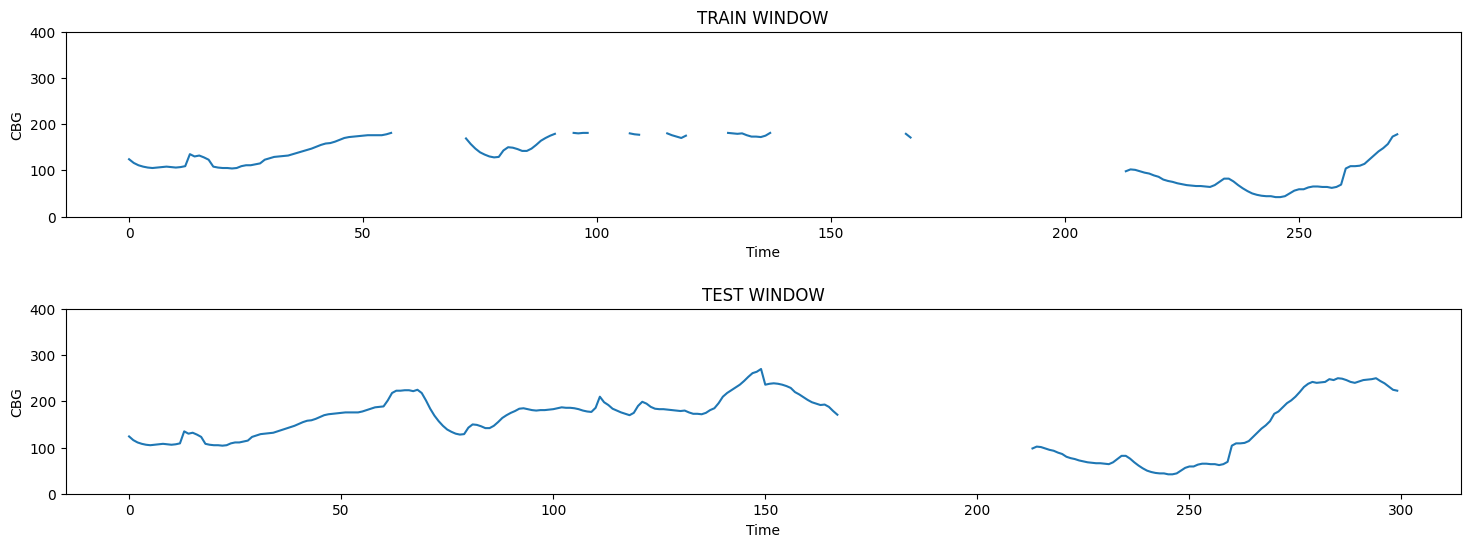

In [26]:
# SANITY CHECK PLOT, WE TAKE A RANDOM TRAIN AND TEST WINDOW TO VERIFY WHETHER THEY CORRESPOND

WINDOW_LEN = np.shape(MASK_WINDOWS)[0]

random_window = np.random.randint(0,WINDOW_LEN)

vis_train = MASK_WINDOWS[random_window]
vis_test = TRUE_WINDOWS[random_window]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 6))
plt.subplots_adjust(hspace=0.5)

ax1.plot(vis_train)
ax1.set_title(f'TRAIN WINDOW')
ax1.set_xlabel("Time")
ax1.set_ylabel("CBG")
ax1.set_ylim(0, 400)

ax2.plot(vis_test)
ax2.set_title(f'TEST WINDOW')
ax2.set_xlabel("Time")
ax2.set_ylabel("CBG")
ax2.set_ylim(0, 400)

plt.show()

<h2> TRAIN TEST SPLITTING

In [27]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='constant', fill_value=-1)

MASK_WINDOWS = imputer.fit_transform(MASK_WINDOWS)
TRUE_WINDOWS = imputer.fit_transform(TRUE_WINDOWS)

In [28]:
X_train, X_val, y_train,y_val = train_test_split(MASK_WINDOWS,TRUE_WINDOWS,test_size=0.2,random_state=seed)

# 3. TRAINING MODELS

In [29]:
models = {
    'LR' : LinearRegression()
}

param_grids = {
    'LR' : {}
}

In [30]:
def bias_metric(y_predicted, y):
    bias = np.mean(y_predicted - y)
    return bias 

In [31]:
best_models = {}
best_score = float('inf')

In [32]:
for model_name, model in models.items():
    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=False,
        return_train_score=True,
    )

    grid_search.fit(X_train, y_train)
    cv_results = grid_search.cv_results_

    best_models[model_name] = grid_search.best_estimator_

    print("=" * 170)
    for i, params in enumerate(cv_results['params']):
        score = abs(cv_results['mean_test_score'][i])
        print(f"[{model_name}]:\t{score}\t\t{params}\t")

[LR]:	2767.993363802159		{}	


# 4. EVALUATION AND METRICS

In [33]:
best_models['LR'].fit(X_train,y_train)

LinearRegression()

In [34]:
y_pred = best_models['LR'].predict(X_val)

In [35]:
print("[BIAS]:\t\t", bias_metric(y_pred,y_val))
print("[MSE]:\t\t", mean_squared_error(y_val,y_pred))

[BIAS]:		 -0.3013142323992642
[MSE]:		 2719.243287059173


In [36]:
print(np.shape(y_pred))
print(np.shape(y_val))

(1004, 300)
(1004, 300)


<h2> Predicted Window Visualization </h2>

In [37]:
y_pred[y_pred == -1] = np.nan
y_val[y_val == -1] = np.nan
X_val[X_val == -1] = np.nan

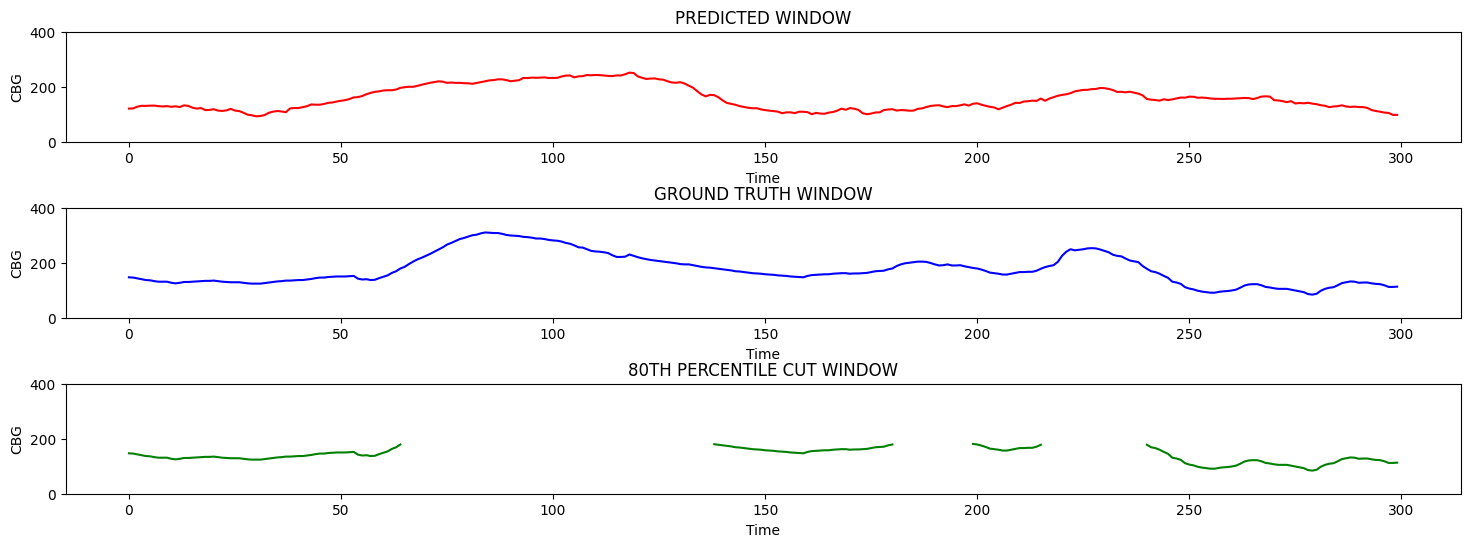

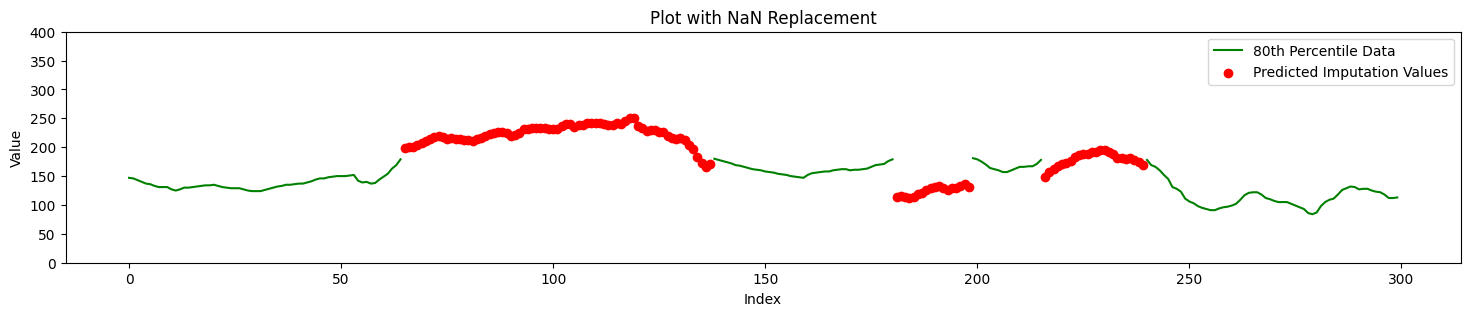

In [46]:
# SANITY CHECK PLOT, WE TAKE A RANDOM TRAIN AND TEST WINDOW TO VERIFY WHETHER THEY CORRESPOND

WINDOW_LEN = np.shape(y_pred)[0]

random_window = np.random.randint(0,WINDOW_LEN)


vis_pred = y_pred[random_window]
vis_val = y_val[random_window]
vis_x = X_val[random_window]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 6))
plt.subplots_adjust(hspace=0.6)

ax1.plot(vis_pred,color='red')
ax1.set_title(f'PREDICTED WINDOW')
ax1.set_xlabel("Time")
ax1.set_ylabel("CBG")
ax1.set_ylim(0, 400)

ax2.plot(vis_val,color='blue')
ax2.set_title(f'GROUND TRUTH WINDOW')
ax2.set_xlabel("Time")
ax2.set_ylabel("CBG")
ax2.set_ylim(0, 400)

ax3.plot(vis_x,color='green')
ax3.set_title(f'80TH PERCENTILE CUT WINDOW')
ax3.set_xlabel("Time")
ax3.set_ylabel("CBG")
ax3.set_ylim(0, 400)

plt.show()



fig, ax = plt.subplots(figsize=(18,3))

ax.plot(vis_x, label='80th Percentile Data', color='green')
# ax.plot(vis_val, label='Original Data', color='blue')

nan_indices = np.isnan(vis_x)

ax.scatter(np.arange(len(vis_val))[nan_indices], vis_pred[nan_indices], 
           color='red', label='Predicted Imputation Values', zorder=2)

ax.set_title('Plot with NaN Replacement')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_ylim(0, 400)
ax.legend()
plt.show()